Opened file set:  /home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/IPSL-CM6A-LR/r8i1p1f1


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for the regridding.
  UserWarning,
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for the regridding.
  UserWarning,


Regridded
(165,)
(165, 28, 144)
found press and temp
found dynamical contribution.


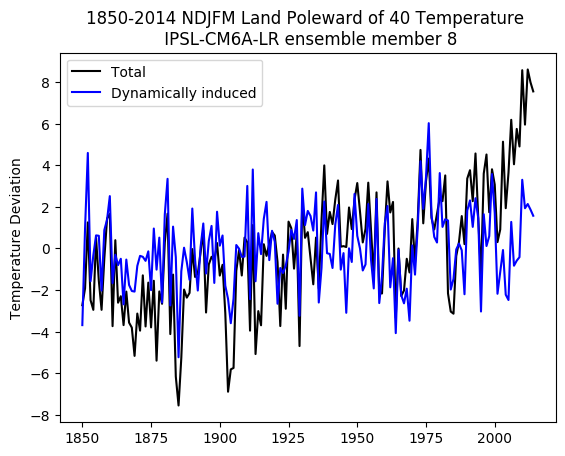

In [11]:
#!/usr/bin/env python3

import numpy as np
import glob
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import os
from sklearn.cross_decomposition import PLSRegression
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import matplotlib.pyplot as plt

# Set up cartopy shape file so that it can distinguish between land and ocean
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def is_land(x, y):
    """
    Uses knowledge of land points to decide whether given location 
    is land or ocean. X is longitude and Y is latitude.
    """
    return land.contains(sgeom.Point(x, y))*1


def find_avg_ts(xarray, land_ocean_map):
    """
    finds area weighted average over a given region
    """
    latitudes = xarray.lat.values
    weights = np.cos(np.deg2rad(latitudes))
    weights_map = np.broadcast_to(weights, (144,72)).T
    temps = xarray.tas.values
    temps_land = np.array([np.ma.masked_array(data=temps[i], mask=abs(land_ocean_map-1), 
                           fill_value=np.nan).filled() for i in range(len(temps))])
    land_weights = np.ma.masked_array(data=weights_map, mask=abs(land_ocean_map-1), 
                                      fill_value=np.nan).filled()
    weighted_temps = np.multiply(temps_land, weights[np.newaxis, :, np.newaxis])
    weighted_temps_region = weighted_temps[:,-20:,:] # this gives north of 40    
    weighted_temps_region = np.reshape(weighted_temps_region, (len(weighted_temps_region), 20*144))
    region_temp_ts = np.nansum(weighted_temps_region, axis=1)/np.nansum(land_weights[:21])
    temp_cal = np.reshape(region_temp_ts, (165,12))
    temp_cal_ndjfma = np.nanmean([temp_cal[:,0], temp_cal[:,1], temp_cal[:,2],
                                  temp_cal[:,10], temp_cal[:,11]], axis=0)
    return(temp_cal_ndjfma)

def nh_winter_press(psl_data_regridded):
    """
    returns average extended winter slp field
    """
    nh_psl = psl_data_regridded.sel(lat=slice(20, 90)).psl.values
    nh_psl_cal = np.reshape(nh_psl, (165,12,np.shape(nh_psl)[1], np.shape(nh_psl)[2]))
    ndjfm_nh_psl_cal = [nh_psl_cal[:,0], nh_psl_cal[:,1], nh_psl_cal[:,2], nh_psl_cal[:,10], nh_psl_cal[:,11]]
    ndjfm_nh_psl_cal = np.nanmean(ndjfm_nh_psl_cal, axis=0)
    return(ndjfm_nh_psl_cal)

# find all potential models
psl_models = glob.glob('/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/*')

for model_path in psl_models[0:-1]:
    model_paths = model_path + '/*'
    psl_files = glob.glob(model_paths)

    psl_and_tas_files = []
    for psl_file in psl_files:
        tas_file = psl_file[:48] + 'tas' + psl_file[51:]
        psl_and_tas_files.append([psl_file, tas_file])

    # define times for final netcdf
    winter_times = np.arange(1850,2015,1)

    true_and_dynamic_ts = []
    for file_set in psl_and_tas_files:
        try:
            psl_data = xr.open_dataset(file_set[0])
            psl_data = psl_data.sel(time=slice('1850-01-01', '2015-01-01'))
            tas_data = xr.open_dataset(file_set[1])
            tas_data = tas_data.sel(time=slice('1850-01-01', '2015-01-01'))
            if len(psl_data.time) != len(tas_data.time):
                continue
            if len(psl_data.time) != 1980:
                continue
            print('Opened file set: ', file_set[0])
        except:
            print('Error opening file set: ', file_set)
            continue

        # CMIP6 models must be regridded, below we define input and output grids
        latitudes = psl_data.lat.values # psl and tas have same grid
        longitudes = psl_data.lon.values
        InputGrid = {"lon": longitudes, "lat": latitudes}
        OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
        regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)
        psl_data_regridded = regridder(psl_data)
        tas_data_regridded = regridder(tas_data)

        # find land ocean map
        land_ocean_map = []
        for lat in tas_data_regridded.lat:
            lat_line = []
            for lon in tas_data_regridded.lon - 180:
                lat_line.append(is_land(lon, lat))
            land_ocean_map.append(lat_line)
        land_ocean_map = np.array(land_ocean_map)
        land_ocean_map = np.concatenate((land_ocean_map[:,72:], land_ocean_map[:,:72]), axis=1)

        print('Regridded')
        # get polar temperature during winter
        ndjfm_temps_cal = find_avg_ts(tas_data_regridded, land_ocean_map)
        print(np.shape(ndjfm_temps_cal))

        # get NH pressure data during winter then weight this by latitude
        ndjfm_nh_psl_cal = nh_winter_press(psl_data_regridded)
        print(np.shape(ndjfm_nh_psl_cal))
        print('found press and temp')

        # preform cross validation of dynamic adjustment
        dynamical_contributions = []
        for x in range(165):
            temp_minus_one_winter = np.delete(ndjfm_temps_cal, x, axis=0)
            pres_minus_one_winter = np.delete(ndjfm_nh_psl_cal, x, axis=0)
            
            # scale X train data 
            pres_minus_one_winter_ts = np.reshape(pres_minus_one_winter, (164,28,144))
            pres_minus_one_winter_mean = np.nanmean(pres_minus_one_winter_ts, axis=0)
            pres_minus_one_winter_mr = pres_minus_one_winter_ts - pres_minus_one_winter_mean
            pres_minus_one_winter_std = np.nanstd(pres_minus_one_winter_mr, axis=0)
            pres_minus_one_winter_scaled = pres_minus_one_winter_mr/pres_minus_one_winter_std

            # scale X test data
            pres_all_mr = ndjfm_nh_psl_cal - pres_minus_one_winter_mean
            pres_all_scaled = pres_all_mr/pres_minus_one_winter_std

            # weight X data by latitude
            weights = np.cos(np.deg2rad(psl_data_regridded.lat.sel(lat=slice(20,90)).values))
            pres_minus_one_winter_weighted = np.multiply(pres_minus_one_winter_scaled, weights[np.newaxis, :,np.newaxis])
            pres_all_scaled_weighted = np.multiply(pres_all_scaled, weights[np.newaxis, :,np.newaxis])

            # scale Y data
            temp_minus_one_winter_ts = np.reshape(temp_minus_one_winter, (164))
            temp_minus_one_winter_mean = np.nanmean(temp_minus_one_winter_ts, axis=0)
            temp_minus_one_winter_mr = temp_minus_one_winter_ts - temp_minus_one_winter_mean
            temp_minus_one_winter_std = np.nanstd(temp_minus_one_winter_mr, axis=0)
            temp_minus_one_winter_scaled = temp_minus_one_winter_mr/temp_minus_one_winter_std

            # define X and Y data
            X = np.reshape(pres_minus_one_winter_weighted, (164, 28*144))
            Y = np.reshape(temp_minus_one_winter_scaled, (164))
            
            # create PLS model with 2 components
            pls = PLSRegression(n_components=2, scale='False')
            pls.fit(X, Y)

            # deploy on all pressure data
            all_pressures = np.reshape(pres_all_scaled_weighted, (165, 28*144))
            temp_dynamical = pls.predict(all_pressures)

            # unscale the data so that units are again in K
            temp_dynamical_multiplied_by_std = temp_dynamical*temp_minus_one_winter_std
            dynamical_contributions.append(temp_dynamical_multiplied_by_std)

        print('found dynamical contribution.')
        # find mean dynamical contribution over all cross validations
        dynamical_mean = np.nanmean(dynamical_contributions, axis=0)[:,0]

        # reshape the raw polar timeseries
        temp_timeseries = ndjfm_temps_cal


        plt.plot(winter_times, temp_timeseries - np.nanmean(temp_timeseries), color='black', label='Total')
        plt.plot(winter_times, dynamical_mean, color='blue', label='Dynamically induced')
        plt.legend(frameon='False')
        plt.ylabel('Temperature Deviation')
        plt.title('1850-2014 NDJFM Land Poleward of 40 Temperature \n IPSL-CM6A-LR ensemble member 8')
        break

        """# create a netcdf file
        storage_path = '/home/disk/pna2/aodhan/CMIP6/historical_dynamical_ts'
        completed_models = glob.glob(storage_path + '/*')
        completed_model_strings = [completed_models[i].split('/')[7] for i in range(0, len(completed_models))]
        model = file_set[0].split('/')[7]
        if model not in completed_model_strings:
            os.mkdir(storage_path + '/' + model)
        simulation = file_set[0].split('/')[8]
        fileName = storage_path + '/' + model + '/' + simulation + '_LandPoleward40.nc'
        ds = nc.Dataset(fileName, 'w', format='NETCDF4')
        
        DynamicalContribution = ds.createDimension('DynamicalContribution', 2)
        time = ds.createDimension('time', 165)

        # Add variables to dimensions
        DynamicalContribution = ds.createVariable('DynamicalContribution', int, ('DynamicalContribution',))
        time = ds.createVariable(varname='time', datatype=int, dimensions=('time',))
        timeseries = ds.createVariable('temp', 'f4', ('DynamicalContribution', 'time'))

        # Assing values to variables
        DynamicalContribution[:] = [0,1]
        time[:] = winter_times
        timeseries[:] = [temp_timeseries, dynamical_mean]

        # close netcdf    
        ds.close()"""
    break


Opened file set:  /home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/IPSL-CM6A-LR/r8i1p1f1


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for the regridding.
  UserWarning,
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for the regridding.
  UserWarning,


Regridded
(165,)
(165, 28, 144)
found press and temp
found dynamical contribution.


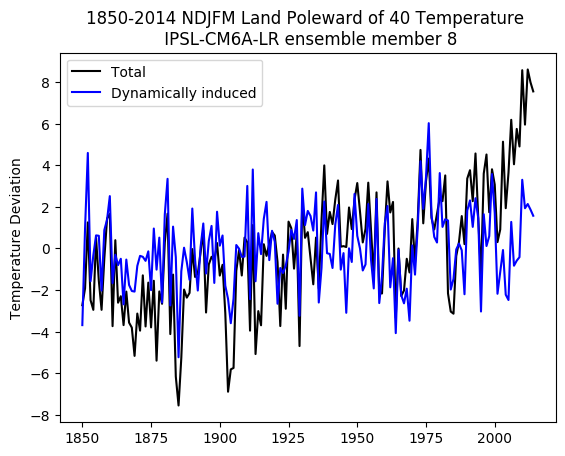

In [20]:
#!/usr/bin/env python3

import numpy as np
import glob
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import os
from sklearn.cross_decomposition import PLSRegression
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import matplotlib.pyplot as plt

# Set up cartopy shape file so that it can distinguish between land and ocean
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def is_land(x, y):
    """
    Uses knowledge of land points to decide whether given location 
    is land or ocean. X is longitude and Y is latitude.
    """
    return land.contains(sgeom.Point(x, y))*1


def find_avg_ts(xarray, land_ocean_map):
    """
    finds area weighted average over a given region
    """
    latitudes = xarray.lat.values
    weights = np.cos(np.deg2rad(latitudes))
    weights_map = np.broadcast_to(weights, (144,72)).T
    temps = xarray.tas.values
    temps_land = np.array([np.ma.masked_array(data=temps[i], mask=abs(land_ocean_map-1), 
                           fill_value=np.nan).filled() for i in range(len(temps))])
    land_weights = np.ma.masked_array(data=weights_map, mask=abs(land_ocean_map-1), 
                                      fill_value=np.nan).filled()
    weighted_temps = np.multiply(temps_land, weights[np.newaxis, :, np.newaxis])
    weighted_temps_region = weighted_temps[:,-20:,:] # this gives north of 40    
    weighted_temps_region = np.reshape(weighted_temps_region, (len(weighted_temps_region), 20*144))
    region_temp_ts = np.nansum(weighted_temps_region, axis=1)/np.nansum(land_weights[:21])
    temp_cal = np.reshape(region_temp_ts, (165,12))
    temp_cal_ndjfma = np.nanmean([temp_cal[:,0], temp_cal[:,1], temp_cal[:,2],
                                  temp_cal[:,10], temp_cal[:,11]], axis=0)
    return(temp_cal_ndjfma)

def nh_winter_press(psl_data_regridded):
    """
    returns average extended winter slp field
    """
    nh_psl = psl_data_regridded.sel(lat=slice(20, 90)).psl.values
    nh_psl_cal = np.reshape(nh_psl, (165,12,np.shape(nh_psl)[1], np.shape(nh_psl)[2]))
    ndjfm_nh_psl_cal = [nh_psl_cal[:,0], nh_psl_cal[:,1], nh_psl_cal[:,2], nh_psl_cal[:,10], nh_psl_cal[:,11]]
    ndjfm_nh_psl_cal = np.nanmean(ndjfm_nh_psl_cal, axis=0)
    return(ndjfm_nh_psl_cal)

# find all potential models
psl_models = glob.glob('/home/disk/pna2/aodhan/CMIP6/historical_monthly_psl_google/*')

for model_path in psl_models[0:-1]:
    model_paths = model_path + '/*'
    psl_files = glob.glob(model_paths)

    psl_and_tas_files = []
    for psl_file in psl_files:
        tas_file = psl_file[:48] + 'tas' + psl_file[51:]
        psl_and_tas_files.append([psl_file, tas_file])

    # define times for final netcdf
    winter_times = np.arange(1850,2015,1)

    true_and_dynamic_ts = []
    for file_set in psl_and_tas_files:
        try:
            psl_data = xr.open_dataset(file_set[0])
            psl_data = psl_data.sel(time=slice('1850-01-01', '2015-01-01'))
            tas_data = xr.open_dataset(file_set[1])
            tas_data = tas_data.sel(time=slice('1850-01-01', '2015-01-01'))
            if len(psl_data.time) != len(tas_data.time):
                continue
            if len(psl_data.time) != 1980:
                continue
            print('Opened file set: ', file_set[0])
        except:
            print('Error opening file set: ', file_set)
            continue

        # CMIP6 models must be regridded, below we define input and output grids
        latitudes = psl_data.lat.values # psl and tas have same grid
        longitudes = psl_data.lon.values
        InputGrid = {"lon": longitudes, "lat": latitudes}
        OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
        regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)
        psl_data_regridded = regridder(psl_data)
        tas_data_regridded = regridder(tas_data)

        # find land ocean map
        land_ocean_map = []
        for lat in tas_data_regridded.lat:
            lat_line = []
            for lon in tas_data_regridded.lon - 180:
                lat_line.append(is_land(lon, lat))
            land_ocean_map.append(lat_line)
        land_ocean_map = np.array(land_ocean_map)
        land_ocean_map = np.concatenate((land_ocean_map[:,72:], land_ocean_map[:,:72]), axis=1)

        print('Regridded')
        # get polar temperature during winter
        ndjfm_temps_cal = find_avg_ts(tas_data_regridded, land_ocean_map)
        print(np.shape(ndjfm_temps_cal))

        # get NH pressure data during winter then weight this by latitude
        ndjfm_nh_psl_cal = nh_winter_press(psl_data_regridded)
        print(np.shape(ndjfm_nh_psl_cal))
        print('found press and temp')

        # preform cross validation of dynamic adjustment
        dynamical_contributions = []
        for x in range(165):
            temp_minus_one_winter = np.delete(ndjfm_temps_cal, x, axis=0)
            pres_minus_one_winter = np.delete(ndjfm_nh_psl_cal, x, axis=0)
            
            # scale X train data 
            pres_minus_one_winter_ts = np.reshape(pres_minus_one_winter, (164,28,144))
            pres_minus_one_winter_mean = np.nanmean(pres_minus_one_winter_ts, axis=0)
            pres_minus_one_winter_mr = pres_minus_one_winter_ts - pres_minus_one_winter_mean
            pres_minus_one_winter_std = np.nanstd(pres_minus_one_winter_mr, axis=0)
            pres_minus_one_winter_scaled = pres_minus_one_winter_mr/pres_minus_one_winter_std

            # scale X test data
            pres_all_mr = ndjfm_nh_psl_cal - pres_minus_one_winter_mean
            pres_all_scaled = pres_all_mr/pres_minus_one_winter_std

            # weight X data by latitude
            weights = np.cos(np.deg2rad(psl_data_regridded.lat.sel(lat=slice(20,90)).values))
            pres_minus_one_winter_weighted = np.multiply(pres_minus_one_winter_scaled, weights[np.newaxis, :,np.newaxis])
            pres_all_scaled_weighted = np.multiply(pres_all_scaled, weights[np.newaxis, :,np.newaxis])

            # scale Y data
            temp_minus_one_winter_ts = np.reshape(temp_minus_one_winter, (164))
            temp_minus_one_winter_mean = np.nanmean(temp_minus_one_winter_ts, axis=0)
            temp_minus_one_winter_mr = temp_minus_one_winter_ts - temp_minus_one_winter_mean
            temp_minus_one_winter_std = np.nanstd(temp_minus_one_winter_mr, axis=0)
            temp_minus_one_winter_scaled = temp_minus_one_winter_mr/temp_minus_one_winter_std

            # define X and Y data
            X = np.reshape(pres_minus_one_winter_weighted, (164, 28*144))
            Y = np.reshape(temp_minus_one_winter_scaled, (164))
            
            # create PLS model with 2 components
            pls = PLSRegression(n_components=2, scale='False')
            pls.fit(X, Y)

            # deploy on all pressure data
            all_pressures = np.reshape(pres_all_scaled_weighted, (165, 28*144))
            temp_dynamical = pls.predict(all_pressures)

            # unscale the data so that units are again in K
            temp_dynamical_multiplied_by_std = temp_dynamical*temp_minus_one_winter_std
            dynamical_contributions.append(temp_dynamical_multiplied_by_std)

        print('found dynamical contribution.')
        # find mean dynamical contribution over all cross validations
        dynamical_mean = np.nanmean(dynamical_contributions, axis=0)[:,0]

        # reshape the raw polar timeseries
        temp_timeseries = ndjfm_temps_cal

        mr_timeseries = temp_timeseries - np.nanmean(temp_timeseries)
        dynamically_adjusted_ts = mr_timeseries - dynamical_mean
        plt.plot(winter_times, mr_timeseries, color='black', label='Total')
        plt.plot(winter_times, dynamical_mean, color='blue', label='Dynamically induced')
        plt.legend(frameon='False')
        plt.ylabel('Temperature Deviation')
        plt.title('1850-2014 NDJFM Land Poleward of 40 Temperature \n IPSL-CM6A-LR ensemble member 8')
        break

        """# create a netcdf file
        storage_path = '/home/disk/pna2/aodhan/CMIP6/historical_dynamical_ts'
        completed_models = glob.glob(storage_path + '/*')
        completed_model_strings = [completed_models[i].split('/')[7] for i in range(0, len(completed_models))]
        model = file_set[0].split('/')[7]
        if model not in completed_model_strings:
            os.mkdir(storage_path + '/' + model)
        simulation = file_set[0].split('/')[8]
        fileName = storage_path + '/' + model + '/' + simulation + '_LandPoleward40.nc'
        ds = nc.Dataset(fileName, 'w', format='NETCDF4')
        
        DynamicalContribution = ds.createDimension('DynamicalContribution', 2)
        time = ds.createDimension('time', 165)

        # Add variables to dimensions
        DynamicalContribution = ds.createVariable('DynamicalContribution', int, ('DynamicalContribution',))
        time = ds.createVariable(varname='time', datatype=int, dimensions=('time',))
        timeseries = ds.createVariable('temp', 'f4', ('DynamicalContribution', 'time'))

        # Assing values to variables
        DynamicalContribution[:] = [0,1]
        time[:] = winter_times
        timeseries[:] = [temp_timeseries, dynamical_mean]

        # close netcdf    
        ds.close()"""
    break
